In [44]:
import os
import glob
import random
import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.functional import F

from sklearn.model_selection import train_test_split

### Define Transforms

In [2]:
train_transformations = transforms.Compose([
    transforms.ToTensor()
])

validation_transformations = transforms.Compose([
    transforms.ToTensor()
])

### Create train, validation sets

In [3]:
benign_path = "features/images/benign/gaf/branch_instructions"
ransomware_path = "features/images/ransomware/gaf/branch_instructions"

train_valid_image_paths = list()
classes = list()

for path in glob.glob(os.path.join(benign_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

for path in glob.glob(os.path.join(ransomware_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

classes = list(set(classes))
random.shuffle(train_valid_image_paths)

print(f"Path example: {train_valid_image_paths[0]}")
print(f"Class example: {classes[0]}")

Path example: features/images/ransomware/gaf/branch_instructions/ransomware_103.jpg
Class example: benign


In [4]:
train_image_paths, valid_image_paths = train_test_split(train_valid_image_paths, train_size=0.7)

print(f"Train size: {len(train_image_paths)}")
print(f"Valid size {len(valid_image_paths)}")

Train size: 280
Valid size 120


In [5]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

idx_to_class

{0: 'benign', 1: 'ransomware'}

### Dataset class

In [6]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create datasets

In [7]:
train_dataset = RansomwareDetectionDataset(train_image_paths, train_transformations)
validation_dataset = RansomwareDetectionDataset(valid_image_paths, validation_transformations)

print(f"Tensor shape of the image: {train_dataset[1][0].shape}")
print(f"Label of the image: {idx_to_class[train_dataset[1][1]]}")

Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: benign


### Create Dataloaders

In [85]:
def create_dataloaders(batch_size=5):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)

    print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
    print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

    return train_dataloader, validation_dataloader

Train dataloader shape torch.Size([5, 3, 50, 50])
Validation dataloader shape torch.Size([5, 3, 50, 50])


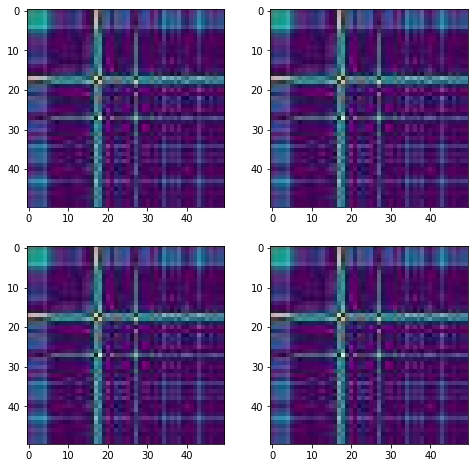

In [86]:
train_loader, validation_loader = create_dataloaders(5)

rows = 2
columns = 2
fig = plt.figure(figsize=(8, 8))

for index in range(0, 4):
    train_image, train_label = next(iter(train_loader))
    valid_image, valid_label = next(iter(validation_loader))
    ax = fig.add_subplot(rows, columns, index + 1)
    plt.imshow(train_image[0].permute(1, 2, 0))
    plt.imshow(valid_image[0].permute(1, 2, 0))


### Create CNN

In [87]:
class SimpleNetwork(pl.LightningModule):
    def __init__(self, number_of_classes, image_size):
        super().__init__()

        self.image_size = image_size
        self.final_size = image_size // 2

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.linear1 = nn.Linear(in_features=5 * self.final_size * self.final_size, out_features=number_of_classes)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = x.flatten(start_dim=1)
        x = self.linear1(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)

        loss = self.loss(output, y)
        self.log("loss", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        accuracy = (torch.argmax(output,dim=1) == y).sum() / len(y)

        self.log("accuracy", accuracy, on_epoch=True, prog_bar=True, logger=True)

        return accuracy

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    


In [88]:
simple_model = SimpleNetwork(number_of_classes=len(classes), image_size=50)

In [89]:
trainer = pl.Trainer(max_epochs=20, log_every_n_steps=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [90]:
trainer.fit(simple_model, train_dataloaders=train_loader, val_dataloaders=validation_loader)


  | Name     | Type             | Params
----------------------------------------------
0 | conv1    | Conv2d           | 140   
1 | maxpool1 | MaxPool2d        | 0     
2 | linear1  | Linear           | 6.3 K 
3 | loss     | CrossEntropyLoss | 0     
----------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.026     Total estimated model params size (MB)


/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/unibern-pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 80/80 [00:02<00:00, 33.78it/s, loss=0.265, v_num=5, loss_step=0.347, accuracy=0.783, loss_epoch=0.240] 


### Verify the model

In [91]:
val_batch, val_label = next(iter(validation_loader))

In [93]:
pred = simple_model(val_batch)
pred = pred.argmax(dim=1)

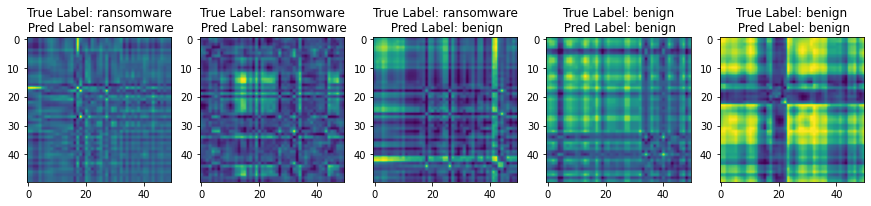

In [97]:
fig, ax = plt.subplots(1, 5, figsize=(15, 8))

for index, image in enumerate(val_batch):
    ax[index].imshow(image[0])
    title = f"True Label: {idx_to_class[val_label[index].item()]}\n Pred Label: {idx_to_class[pred[index].item()]}"
    ax[index].set_title(title)